In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random
import mutation
import crossover
import generator
import fitness
from datetime import datetime

In [2]:
# user given constants
src=0
dst=1
bandwidth_threshold = 2
# parameters
generation = 10000
max_depth = 5
k_shortest = 5


In [3]:
random.seed(datetime.now())

In [4]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values

# Use generator
#bandwidth_matrix = generator.generate("complete", (1, 15), n=15).out(type="2d_list")
bandwidth_matrix = generator.generate("random", (1, 100), n=1000, p=0.1).out(type="2d_list")


#bandwidth_matrix = csv_to_np('test1.csv')
#print(type(bandwidth_matrix), '\n', bandwidth_matrix)

In [5]:
def np_to_nx(bandwidth_matrix):
    # build neighbor matrix
    neighbor_matrix = []
    for row, _ in enumerate(bandwidth_matrix):
        neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    neighbor_matrix = np.array(neighbor_matrix)
    
    # build the list of edges
    edges = np.array(np.where(bandwidth_matrix > 0)).transpose()

    # build nx Graph instance
    G = nx.Graph()
    num_of_nodes = bandwidth_matrix.shape[0]
    G.add_nodes_from(range(num_of_nodes))
    G.add_edges_from(edges)
    return G, neighbor_matrix
    
G, neighbor_matrix = np_to_nx(bandwidth_matrix)

/home/phua/anaconda3/envs/evo/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


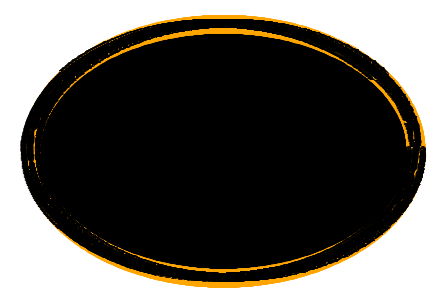

In [6]:
def nx_visualize(G):
    # Visualize the graph
    %matplotlib inline
    nx.draw_shell(G, with_labels=True, node_color='orange')

nx_visualize(G)

In [7]:
def random_walk(src, step, neighbor_matrix):
    path=[src]
    for i in range(step):
        next_node = random.choice(neighbor_matrix[src])
        path.append(next_node)
    return crossover.check_cycle(path)

In [8]:
def initial(G, s, d, iddfs_depth, population_size, neighbor_matrix):

    # Add shortest paths (seeding)
    #shortest_path_generator = nx.all_shortest_paths(G, source=s, target=d)
    #shortest_paths = list(shortest_path_generator)
    ##shortest_paths=[]
    
    # Add worse path
    ##path_generator = nx.all_simple_paths(G, source=s, target=d, cutoff=iddfs_depth)
    ##paths = list(path_generator)
    #population_size = min(len(paths), population_size)

    ##long_paths = random.sample(paths, population_size - len(shortest_paths))
    #print("short:", shortest_paths)
    #print("long:", long_paths)
    #global bandwidth_matrix
    #for p in paths:
      #  fit = fitness.fitness(p, bandwidth_matrix)

        #print(fitness.fitness(p, bandwidth_matrix), end=',')
    ##return shortest_paths+long_paths
    
    random_path1 = random_walk(s, G.order(), neighbor_matrix)
    random_path2 = random_path1.copy()
    for i in range(int(0.5*len(random_path1))):
        random_path2 = mutation.mutation(neighbor_matrix, random_path2)
    random_path2 = crossover.check_cycle(random_path2)
        
    population = [random_path1, random_path2]
    while(True):
        children_pop = []
        for idx in range(len(population)-1):
            child1, child2 = crossover.random_crossover(population[idx], population[idx+1], bandwidth_matrix)
            #print(child1)
            #print(crossover.check_cycle(child1))
            #input()
            population += [crossover.check_cycle(child1), crossover.check_cycle(child2)]
    
        # mutation
        for ind in population:
            children_pop.append(crossover.check_cycle(mutation.mutation(neighbor_matrix, ind)))
            
        population += children_pop
        
        if len(population) > population_size:
            break
    #print(population)
    population = random.sample(population, population_size)
    #print(len(population), population_size)
    return population

In [9]:
# Edge density of graph
# This is for calculating parameter (但現在還沒做)
edge_density = G.size()*2/G.order()*(G.order()-1)
print(edge_density)

99997.902


In [22]:
candidate = np.linspace(0.1,0.2, num=2)
candidate = [0.01]
for ratio in candidate:
    population_size = min(200, max(int(ratio * edge_density), k_shortest))
    # for example, given src=0, dst=3, max_depth=7, population_size=20
    pop = initial(G, src, dst, max_depth, population_size, neighbor_matrix)
    #print(pop)

In [23]:
get_path_length(pop)

[7,
 5,
 5,
 6,
 7,
 5,
 7,
 7,
 7,
 7,
 5,
 5,
 7,
 9,
 9,
 9,
 9,
 9,
 7,
 7,
 8,
 9,
 5,
 7,
 9,
 8,
 5,
 5,
 7,
 2,
 7,
 5,
 3,
 5,
 10,
 7,
 7,
 3,
 7,
 4,
 3,
 7,
 7,
 9,
 7,
 5,
 3,
 5,
 7,
 7,
 5,
 8,
 7,
 3,
 7,
 7,
 7,
 7,
 3,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 3,
 5,
 9,
 7,
 7,
 8,
 7,
 2,
 5,
 9,
 7,
 9,
 7,
 8,
 4,
 3,
 7,
 9,
 4,
 3,
 7,
 5,
 7,
 9,
 8,
 7,
 3,
 5,
 7,
 7,
 6,
 7,
 7,
 5,
 4,
 9,
 7,
 4,
 3,
 7,
 5,
 5,
 3,
 7,
 3,
 5,
 7,
 7,
 7,
 3,
 6,
 7,
 5,
 5,
 7,
 5,
 7,
 8,
 7,
 4,
 5,
 5,
 7,
 2,
 5,
 7,
 7,
 5,
 5,
 4,
 7,
 5,
 5,
 9,
 5,
 8,
 3,
 3,
 5,
 8,
 5,
 6,
 7,
 6,
 7,
 3,
 7,
 3,
 5,
 7,
 7,
 6,
 7,
 7,
 5,
 5,
 6,
 9,
 3,
 5,
 5,
 5,
 4,
 5,
 3,
 5,
 8,
 7,
 8,
 5,
 5,
 7,
 7,
 5,
 7,
 7,
 7,
 5,
 7,
 5,
 7,
 7,
 6,
 10,
 5,
 5,
 7,
 5,
 7,
 5,
 3]

In [11]:
# main loop
fit_v_gen = []
for g in range(generation):
    #display(pd.DataFrame(fitness.population_with_fitness(pop, bandwidth_matrix)))
    
    # crossover
    temp_pop = []
    for idx in range(len(pop)-1):
        child1, child2 = crossover.random_crossover(pop[idx], pop[idx+1], bandwidth_matrix)
        #print(child1)
        #print(crossover.check_cycle(child1))
        #input()
        temp_pop += [crossover.check_cycle(child1), crossover.check_cycle(child2)]
    
    # mutation
    children_pop = []
    for ind in temp_pop:
        children_pop.append(crossover.check_cycle(mutation.mutation(neighbor_matrix, ind)))

    # diversity maintenance
    pop = np.unique(pop+temp_pop+children_pop).tolist()
    
    # fitness evaluation
    try:
        pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
    except:
        print(pop)
    
    # selection
    pop = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
    fit_v_gen.append(np.mean(pop['fitness'][:k_shortest]))
    #display(pop)
    pop = pop['individual'][0:population_size].tolist()

def get_path_length(pop):
    # count path length of each individual
    path_length = []
    for ind in pop:
        path_length.append(len(ind))
    return path_length

In [12]:
pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
rst['hop'] = get_path_length(pop)
rst.head(k_shortest)

,fitness,individual,hop
0,5761,"[0, 816, 851, 816, 957, 981, 146, 40, 199]",9
1,5761,"[0, 816, 883, 816, 957, 981, 146, 40, 199]",9
2,5761,"[0, 816, 957, 509, 957, 981, 146, 40, 199]",9
3,5761,"[0, 816, 957, 981, 146, 40, 199]",7
4,5761,"[0, 816, 957, 981, 146, 40, 199, 456, 199]",9


In [13]:
# Ref: https://pythonhealthcare.org/tag/pareto-front/
def identify_pareto(scores):
    
    # flip num_of_hops to negative so that we can maxmize it
    scores[:,1] = -scores[:,1]
    
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
   
    # Add the right-most & down-most points
    max_bandwidth = max(scores[:, 0])
    min_length = max(scores[:, 1])

    for i in range(population_size):
        if scores[i][0] == max_bandwidth or scores[i][1] == min_length:
            pareto_front[i] = 1
    
    
    # flip back the negative sign of num_of_hops
    scores[:,1] = -scores[:,1]
    
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]


In [14]:
data = rst.drop(columns='individual').values
front_idx = identify_pareto(data)
pareto_front= data[front_idx]
pareto_front.sort(axis=0)
pareto_front

array([[3431,    4],
       [5536,    5],
       [5761,    7],
       [5761,    9],
       [5761,    9],
       [5761,    9],
       [5761,    9]])

In [15]:
all(data[0] > data[1]) 

False

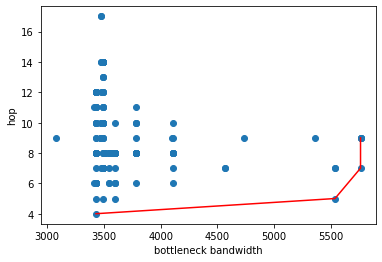

In [16]:
import matplotlib.pyplot as plt
plt.scatter(rst['fitness'], rst['hop'])
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='r')
plt.xlabel('bottleneck bandwidth')
plt.ylabel('hop')
plt.show()
#plt.

In [17]:
rst

,fitness,individual,hop
0,5761,"[0, 816, 851, 816, 957, 981, 146, 40, 199]",9
1,5761,"[0, 816, 883, 816, 957, 981, 146, 40, 199]",9
2,5761,"[0, 816, 957, 509, 957, 981, 146, 40, 199]",9
3,5761,"[0, 816, 957, 981, 146, 40, 199]",7
4,5761,"[0, 816, 957, 981, 146, 40, 199, 456, 199]",9
5,5536,"[0, 282, 146, 40, 199]",5
6,5536,"[0, 282, 146, 502, 146, 40, 199]",7
7,5536,"[0, 282, 146, 981, 146, 40, 199]",7
8,5360,"[0, 816, 130, 816, 957, 981, 146, 40, 199]",9
9,4736,"[0, 816, 957, 589, 957, 981, 146, 40, 199]",9


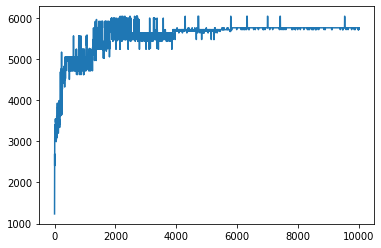

In [18]:
plt.plot(fit_v_gen)

In [19]:
max_band = max(bandwidth_matrix.flatten())
np.where(bandwidth_matrix==max_band)

(array([744, 903]), array([903, 744]))

In [20]:
 max(bandwidth_matrix.flatten())

564873